# How far is the Brick into the Galactic Center?

Assuming the NSD is a symmetric stellar distribution, the relative number of stars seen toward the Brick and away should represent its depth into the NSD.

For the first bit, we try to measure what that relative fraction is - i.e., what is the density of stars on the sky toward/away from the brick, and how does that compare to the density in "control" regions around it?

In the next section, we'll compare to models.

In [424]:
from astropy.table import Table
from astropy.io import fits
from astropy import wcs
import regions
import pylab as pl

In [484]:
basetable = tbl = Table.read('/Users/adam/Dropbox/brick2221/20240802_FITS/basic_merged_indivexp_photometry_tables_merged.fits')
snrgt10 = np.array([basetable[colname] < 0.1 for colname in basetable.colnames if colname.startswith('emag')]).any(axis=0)
snrgt10 &= np.array([basetable[colname] > 4 for colname in basetable.colnames if colname.startswith('nmatch')]).any(axis=0)
basetable[snrgt10].write('/Users/adam/Dropbox/brick2221/20240802_FITS/basic_merged_indivexp_photometry_tables_merged_snrgt10.fits',
                          overwrite=True)
snrgt10.sum(), len(basetable)

(1009128, 2922158)

In [426]:
basetable = basetable[snrgt10]

In [427]:
fh = fits.open('/Users/adam/Dropbox/brick2221/20240802_FITS/jw02221-o001_t001_nircam_clear-f410m-merged_i2d.fits')
ww = wcs.WCS(fh['SCI'].header)

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.661125 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526408297.850 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [428]:
bigbrickreg = regions.Regions.read('/Users/adam//work/brick/jwst/brick-jwst-2221/regions_/brickoutline.reg')[0]
wholebrickreg = regions.Regions.read('/Users/adam//work/brick/jwst/brick-jwst-2221/regions_/dark_innerbrick_polygon.reg')[0]

In [429]:
wholebrick_mask_410 = wholebrickreg.to_pixel(ww).to_mask()
bigbrick_mask_410 = bigbrickreg.to_pixel(ww).to_mask()
pixels_in_brick = np.isfinite(fh['SCI'].data) & (wholebrick_mask_410.to_image(fh['SCI'].data.shape).astype('bool'))
pixels_in_big_brick = np.isfinite(fh['SCI'].data) & (bigbrick_mask_410.to_image(fh['SCI'].data.shape).astype('bool'))
pixels_not_in_brick = np.isfinite(fh['SCI'].data) & ~(pixels_in_brick.astype('bool')) & ~(pixels_in_big_brick.astype('bool'))

f410_area_in_brick = pixels_in_brick.sum() * ww.proj_plane_pixel_area()
f410_area_not_in_brick = pixels_not_in_brick.sum() * ww.proj_plane_pixel_area()
f410_area_in_brick, f410_area_not_in_brick

(<Quantity 0.0008134 deg2>, <Quantity 0.00145862 deg2>)

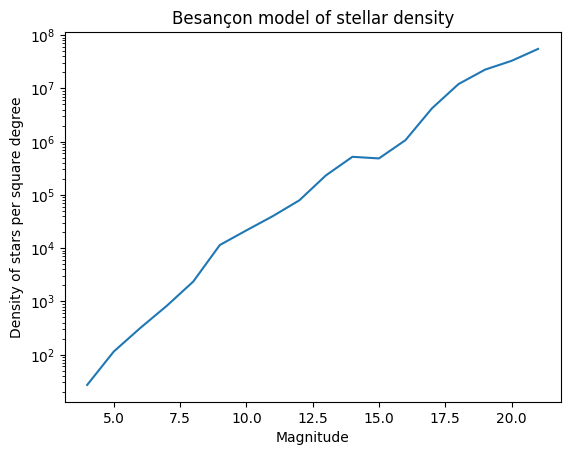

In [430]:
besancon_kcounts = Table.read('https://model.obs-besancon.fr/data/TableK1.res1', format='ascii')
besancon_kcounts.rename_column('N*', 'N10')
besancon_mag_cols = [x for x in besancon_kcounts.colnames if 'N' in x and len(x) > 1]
besancon_mag = [int(x[1:]) for x in besancon_mag_cols]
row = (besancon_kcounts['longitude'] == 0) & (besancon_kcounts['latitude'] == 0)
besancon_n = np.array(besancon_kcounts[row][besancon_mag_cols]).view(float)
pl.semilogy(besancon_mag, besancon_n);
pl.xlabel("Magnitude")
pl.ylabel("Density of stars per square degree");
pl.title("Besançon model of stellar density");

In [431]:
f410_area_in_brick

<Quantity 0.0008134 deg2>

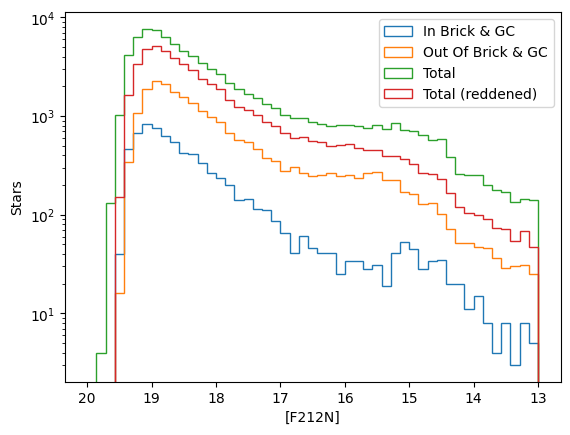

In [485]:
sel = wholebrickreg.contains(basetable['skycoord_ref'], ww)
nonbrick_sel = ~bigbrickreg.contains(basetable['skycoord_ref'], ww)
ok = (basetable['mag_ab_f182m'] - basetable['mag_ab_f212n']) > 0.5 # reddened = GC
#sel &= (basetable['mag_ab_f182m'] - basetable['mag_ab_f212n']) < 0.75 # 
ok &= basetable['emag_ab_f212n'] < 0.1 # min SNR
ok &= basetable['nmatch_good_f212n'] > 4
H1, L1, (p1,) = pl.hist(basetable['mag_ab_f212n'][ok & sel], bins=np.linspace(13, 20), histtype='step', label='In Brick & GC',)
H2, L2, (p2,) =pl.hist(basetable['mag_ab_f212n'][ok & nonbrick_sel], bins=np.linspace(13, 20), histtype='step', label='Out Of Brick & GC',)
H3, L3, (p3,) =pl.hist(basetable['mag_ab_f212n'][basetable['emag_ab_f212n'] < 0.1], bins=np.linspace(13, 20), histtype='step', label='Total',)
H3, L3, (p3,) =pl.hist(basetable['mag_ab_f212n'][ok], bins=np.linspace(13, 20), histtype='step', label='Total (reddened)',)
pl.xlim(pl.xlim()[::-1]);
pl.legend(loc='best');
pl.yscale('log')
pl.xlabel("[F212N]");
pl.ylabel("Stars");

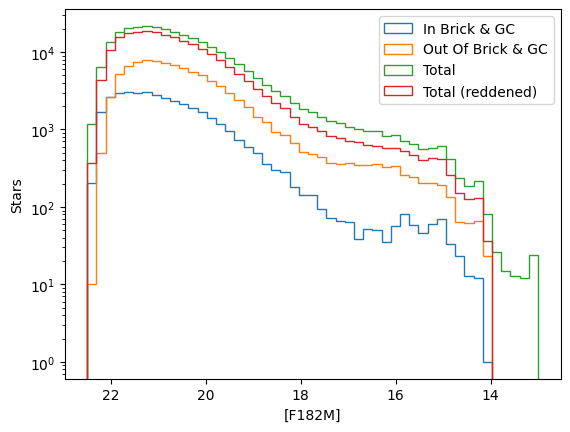

In [486]:
sel = wholebrickreg.contains(basetable['skycoord_ref'], ww)
nonbrick_sel = ~bigbrickreg.contains(basetable['skycoord_ref'], ww)
ok = (basetable['mag_ab_f182m'] - basetable['mag_ab_f212n']) > 0.5 # reddened = GC
#sel &= (basetable['mag_ab_f182m'] - basetable['mag_ab_f212n']) < 0.75 # 
ok &= basetable['emag_ab_f182m'] < 0.1 # min SNR
ok &= basetable['nmatch_good_f182m'] > 4
H1, L1, (p1,) = pl.hist(basetable['mag_ab_f182m'][ok & sel], bins=np.linspace(13, 22.5), histtype='step', label='In Brick & GC',)
H2, L2, (p2,) =pl.hist(basetable['mag_ab_f182m'][ok & nonbrick_sel], bins=np.linspace(13, 22.5), histtype='step', label='Out Of Brick & GC',)
H3, L3, (p3,) =pl.hist(basetable['mag_ab_f182m'][basetable['emag_ab_f182m'] < 0.1], bins=np.linspace(13, 22.5), histtype='step', label='Total',)
H3, L3, (p3,) =pl.hist(basetable['mag_ab_f182m'][ok], bins=np.linspace(13, 22.5), histtype='step', label='Total (reddened)',)
pl.xlim(pl.xlim()[::-1]);
pl.legend(loc='best');
pl.yscale('log')
pl.xlabel("[F182M]");
pl.ylabel("Stars");

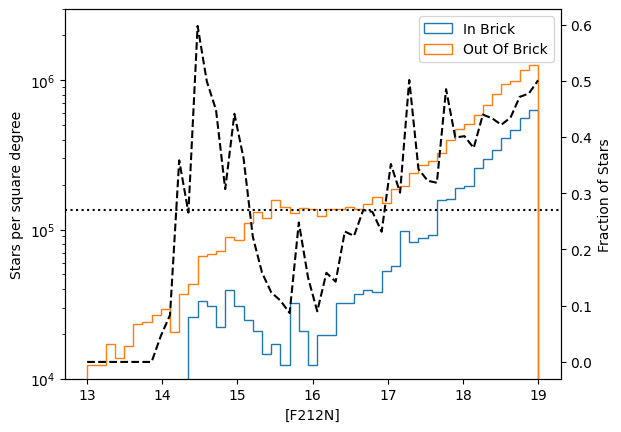

In [493]:
sel = wholebrickreg.contains(basetable['skycoord_ref'], ww)
nonbrick_sel = ~bigbrickreg.contains(basetable['skycoord_ref'], ww)
ok = (basetable['mag_ab_f182m'] - basetable['mag_ab_f212n']) > 0.5 # reddened = GC
sel &= (basetable['mag_ab_f182m'] - basetable['mag_ab_f212n']) < 0.75 # avoid super-reddened to see if ignoring stars embedded in the brick helps
ok &= basetable['emag_ab_f212n'] < 0.1 # min SNR
ok &= basetable['nmatch_good_f182m'] > 4
ok &= basetable['nmatch_good_f212n'] > 4
H1, L1, (p1,) = pl.hist(basetable['mag_ab_f212n'][ok & sel], bins=np.linspace(13, 19), histtype='step', label='In Brick',)
H2, L2, (p2,) =pl.hist(basetable['mag_ab_f212n'][ok & nonbrick_sel], bins=np.linspace(13, 19), histtype='step', label='Out Of Brick',)
#pl.plot(besancon_mag, besancon_n * f410_area_in_brick / (1*u.deg)**2, color='r');
pl.xlim(pl.xlim()[::-1]);
pl.legend(loc='best');
p1.set_xy(np.transpose([p1.xy[:,0], p1.xy[:, 1] / f410_area_in_brick.value]))
p2.set_xy(np.transpose([p2.xy[:,0], p2.xy[:, 1] / f410_area_not_in_brick.value]))
pl.ylim(1e4, 3e6); pl.yscale('log');
pl.xlabel("[F212N]");
pl.ylabel("Stars per square degree")

ax2 = pl.twinx()

ratio_212 = H1 / H2 * f410_area_not_in_brick.value/f410_area_in_brick.value
ax2.plot(L1, np.concatenate([[0], ratio_212]), color='k', linestyle='--')
ax2.axhline(np.nanmedian(ratio_212), linestyle=':', color='k')

ax2.set_xlabel("[F212N]")
ax2.set_ylabel("Fraction of Stars");
ax2.set_xlim(pl.xlim()[::-1]);

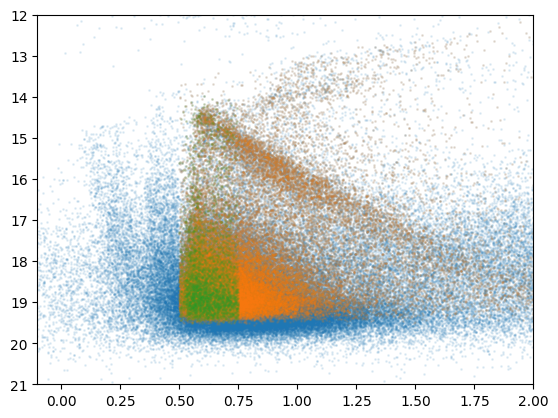

In [488]:
pl.scatter(basetable['mag_ab_f182m'] - basetable['mag_ab_f212n'], basetable['mag_ab_f212n'], s=1, alpha=0.1)
pl.scatter((basetable['mag_ab_f182m'] - basetable['mag_ab_f212n'])[ok], basetable['mag_ab_f212n'][ok], s=1, alpha=0.1)
pl.scatter((basetable['mag_ab_f182m'] - basetable['mag_ab_f212n'])[ok & sel], basetable['mag_ab_f212n'][ok & sel], s=1, alpha=0.1)
pl.axis([-0.1, 2, 21, 12]);

Text(0, 0.5, '[F212N]')

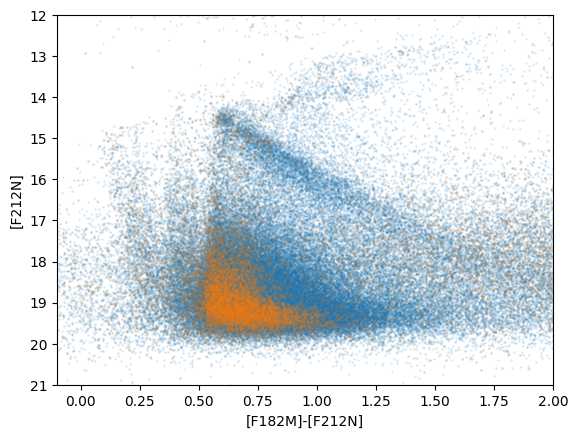

In [489]:
pl.scatter(basetable['mag_ab_f182m'] - basetable['mag_ab_f212n'], basetable['mag_ab_f212n'], s=1, alpha=0.1)
incl = wholebrickreg.contains(basetable['skycoord_ref'], ww)
pl.scatter((basetable['mag_ab_f182m'] - basetable['mag_ab_f212n'])[incl], basetable['mag_ab_f212n'][incl], s=1, alpha=0.1)
pl.axis([-0.1, 2, 21, 12]);
pl.xlabel("[F182M]-[F212N]")
pl.ylabel("[F212N]")

### Pseudo-extinction-maps

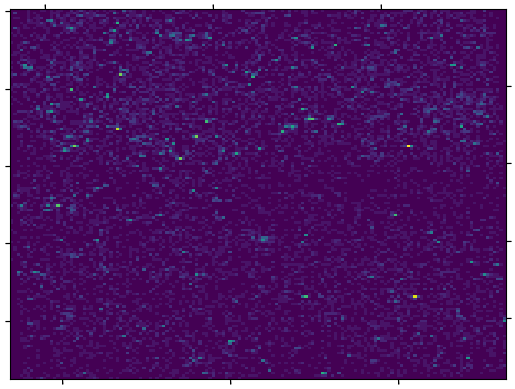

In [534]:
crds = basetable['skycoord_ref']
color = basetable['mag_ab_f182m'] - basetable['mag_ab_f212n']
ax = pl.subplot(projection=ww)
ax.hist2d(crds[color < 0.5].ra.value, crds[color < 0.5].dec.value, bins=[150,150]);

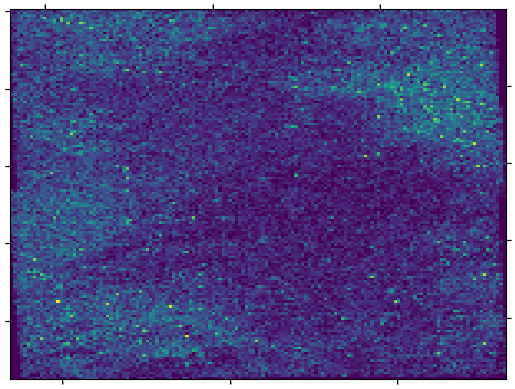

In [535]:
crds = basetable['skycoord_ref']
color = basetable['mag_ab_f182m'] - basetable['mag_ab_f212n']
ax = pl.subplot(projection=ww)
sel = (color > 0.5) & (color < 1.5)
ax.hist2d(crds[sel].ra.value, crds[sel].dec.value, bins=[150,150]);

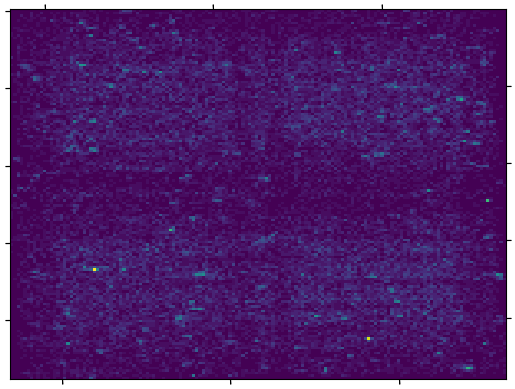

In [537]:
crds = basetable['skycoord_ref']
color = basetable['mag_ab_f182m'] - basetable['mag_ab_f212n']
ax = pl.subplot(projection=ww)
sel = (color > 1.5) & (color < 3.5)
ax.hist2d(crds[sel].ra.value, crds[sel].dec.value, bins=[150,150]);

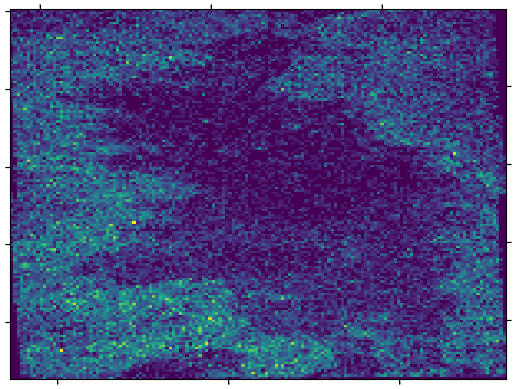

In [547]:
crds = basetable['skycoord_ref']
color = basetable['mag_ab_f182m'] - basetable['mag_ab_f410m']
ax = pl.subplot(projection=ww)
sel = (color > 2.5) & (color < 3.5)
ax.hist2d(crds[sel].ra.value, crds[sel].dec.value, bins=[150,150]);

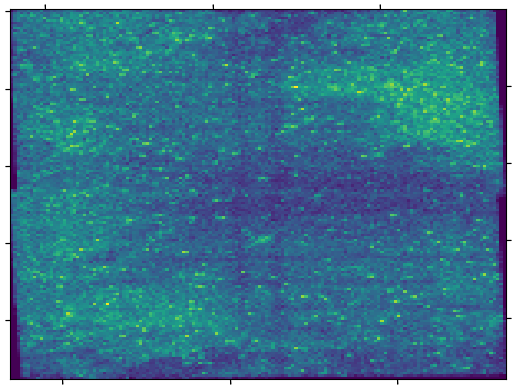

In [539]:
crds = basetable['skycoord_ref']
color = basetable['mag_ab_f182m'] - basetable['mag_ab_f212n']
ax = pl.subplot(projection=ww)
sel = basetable['mag_ab_f182m'] > 14
ax.hist2d(crds.ra.value[sel], crds.dec.value[sel], bins=[150,150]);

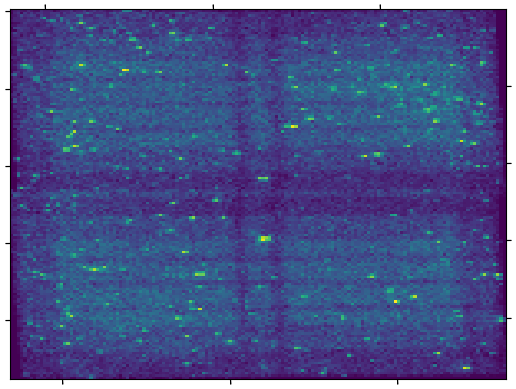

In [543]:
crds = basetable['skycoord_ref']
ax = pl.subplot(projection=ww)
sel = basetable['mag_ab_f212n'] > 14
ax.hist2d(crds.ra.value[sel], crds.dec.value[sel], bins=[150,150]);

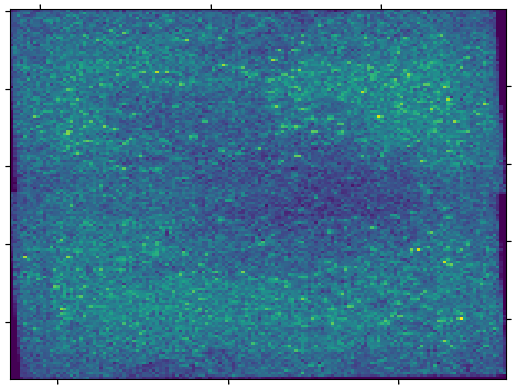

In [544]:
crds = basetable['skycoord_ref']
ax = pl.subplot(projection=ww)
sel = basetable['mag_ab_f410m'] > 14
ax.hist2d(crds.ra.value[sel], crds.dec.value[sel], bins=[150,150]);

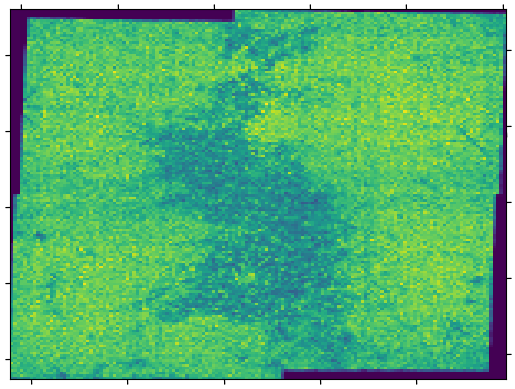

In [540]:
crds = basetable['skycoord_ref']
ax = pl.subplot(projection=ww)
sel = basetable['mag_ab_f200w'] > 14
ax.hist2d(crds.ra.value[sel], crds.dec.value[sel], bins=[150,150]);

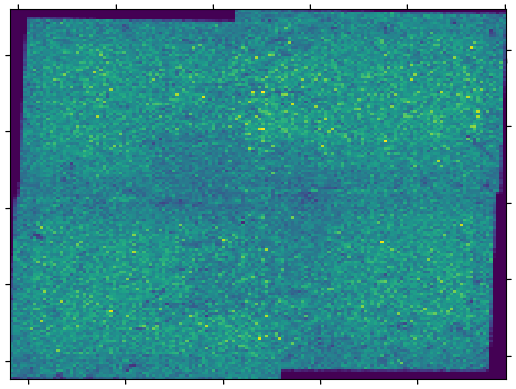

In [545]:
crds = basetable['skycoord_ref']
ax = pl.subplot(projection=ww)
sel = basetable['mag_ab_f356w'] > 13
ax.hist2d(crds.ra.value[sel], crds.dec.value[sel], bins=[150,150]);

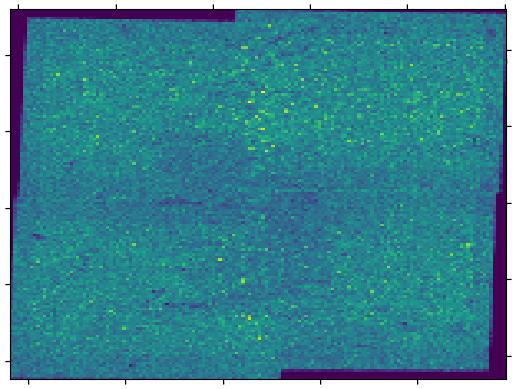

In [542]:
crds = basetable['skycoord_ref']
ax = pl.subplot(projection=ww)
sel = basetable['mag_ab_f444w'] > 13
ax.hist2d(crds.ra.value[sel], crds.dec.value[sel], bins=[150,150]);

### red clump only

In [491]:
mag_ab_f182m = basetable['mag_ab_f182m']
mag_ab_f212n = basetable['mag_ab_f212n']
slope = 3.5
intcpt = 12.2
width = 0.5
redclump = ((mag_ab_f212n > ((slope * (mag_ab_f182m-mag_ab_f212n) + intcpt))) &
            (mag_ab_f212n < ((slope * (mag_ab_f182m-mag_ab_f212n) + intcpt + width))))

redclump &= basetable['nmatch_good_f182m'] > 4
redclump &= basetable['nmatch_good_f212n'] > 4

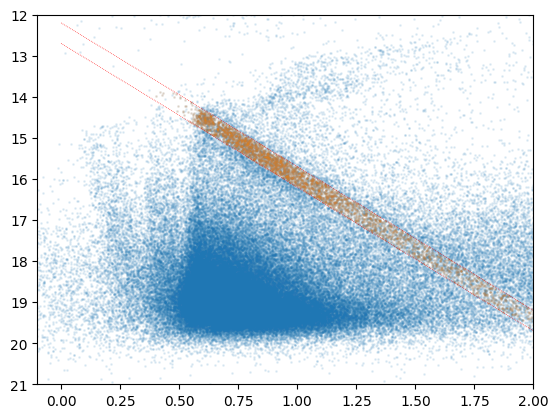

In [492]:
pl.scatter(basetable['mag_ab_f182m'] - basetable['mag_ab_f212n'], basetable['mag_ab_f212n'], s=1, alpha=0.1)
#pl.scatter((basetable['mag_ab_f182m'] - basetable['mag_ab_f212n'])[ok], basetable['mag_ab_f212n'][ok], s=1, alpha=0.1)
pl.scatter((basetable['mag_ab_f182m'] - basetable['mag_ab_f212n'])[redclump], basetable['mag_ab_f212n'][redclump], s=1, alpha=0.1)
pl.plot(np.arange(5), slope * np.arange(5) + intcpt, color='r', linestyle=':', linewidth=0.5)
pl.plot(np.arange(5), slope * np.arange(5) + intcpt + width, color='r', linestyle=':', linewidth=0.5)
pl.axis([-0.1, 2, 21, 12]);

/var/folders/k_/7qh4l0nn72b7qgq15pkd4hw40000gt/T/ipykernel_75926/723123440.py:22: RuntimeWarning: invalid value encountered in divide
  ratio_212 = H1 / H2 * f410_area_not_in_brick.value/f410_area_in_brick.value


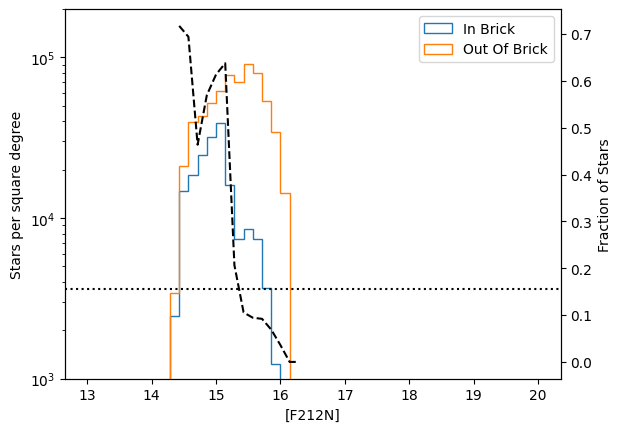

In [494]:
sel = wholebrickreg.contains(basetable['skycoord_ref'], ww)
nonbrick_sel = ~bigbrickreg.contains(basetable['skycoord_ref'], ww)
ok = redclump & ((mag_ab_f182m - mag_ab_f212n) > 0.6)
ok &= ((mag_ab_f182m - mag_ab_f212n) < 1)
sel &= redclump
ok &= basetable['emag_ab_f212n'] < 0.1 # min SNR
ok &= basetable['nmatch_good_f182m'] > 4
ok &= basetable['nmatch_good_f212n'] > 4
H1, L1, (p1,) = pl.hist(basetable['mag_ab_f212n'][ok & sel], bins=np.linspace(13, 20), histtype='step', label='In Brick',)
H2, L2, (p2,) =pl.hist(basetable['mag_ab_f212n'][ok & nonbrick_sel], bins=np.linspace(13, 20), histtype='step', label='Out Of Brick',)
#pl.plot(besancon_mag, besancon_n * f410_area_in_brick / (1*u.deg)**2, color='r');
pl.xlim(pl.xlim()[::-1]);
pl.legend(loc='best');
p1.set_xy(np.transpose([p1.xy[:,0], p1.xy[:, 1] / f410_area_in_brick.value]))
p2.set_xy(np.transpose([p2.xy[:,0], p2.xy[:, 1] / f410_area_not_in_brick.value]))
pl.ylim(1e3, 2e5); pl.yscale('log');
pl.xlabel("[F212N]");
pl.ylabel("Stars per square degree")

ax2 = pl.twinx()

ratio_212 = H1 / H2 * f410_area_not_in_brick.value/f410_area_in_brick.value
ax2.plot(L1, np.concatenate([[0], ratio_212]), color='k', linestyle='--')
ax2.axhline(np.nanmedian(ratio_212), linestyle=':', color='k')

ax2.set_xlabel("[F212N]")
ax2.set_ylabel("Fraction of Stars");
ax2.set_xlim(pl.xlim()[::-1]);

## F410M

/var/folders/k_/7qh4l0nn72b7qgq15pkd4hw40000gt/T/ipykernel_75926/1758862922.py:19: RuntimeWarning: divide by zero encountered in divide
  ratio_410 = H1 / H2 * f410_area_not_in_brick.value/f410_area_in_brick.value
/var/folders/k_/7qh4l0nn72b7qgq15pkd4hw40000gt/T/ipykernel_75926/1758862922.py:19: RuntimeWarning: invalid value encountered in divide
  ratio_410 = H1 / H2 * f410_area_not_in_brick.value/f410_area_in_brick.value


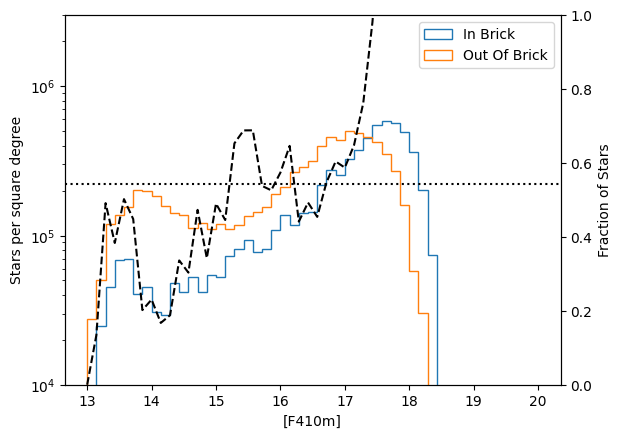

In [495]:
ok = (basetable['mag_ab_f212n'] - basetable['mag_ab_f410m']) > 1.0 # reddened = GC
ok &= basetable['emag_ab_f410m'] < 0.1 # min SNR
ok &= basetable['nmatch_good_f410m'] > 4
ok &= basetable['nmatch_good_f212n'] > 4
sel = wholebrickreg.contains(basetable['skycoord_ref'], ww)
nonbrick_sel = ~bigbrickreg.contains(basetable['skycoord_ref'], ww)
H1, L1, (p1,) = pl.hist(basetable['mag_ab_f410m'][ok & sel], bins=np.linspace(13, 20), histtype='step', label='In Brick',)
H2, L2, (p2,) =pl.hist(basetable['mag_ab_f410m'][ok & nonbrick_sel], bins=np.linspace(13, 20), histtype='step', label='Out Of Brick',)
pl.xlim(pl.xlim()[::-1]);
pl.legend(loc='best');
p1.set_xy(np.transpose([p1.xy[:,0], p1.xy[:, 1] / f410_area_in_brick.value]))
p2.set_xy(np.transpose([p2.xy[:,0], p2.xy[:, 1] / f410_area_not_in_brick.value]))
pl.ylim(1e4, 3e6); pl.yscale('log');
pl.xlabel("[F410m]");
pl.ylabel("Stars per square degree")

ax2 = pl.twinx()

ratio_410 = H1 / H2 * f410_area_not_in_brick.value/f410_area_in_brick.value
ax2.plot(L1, np.concatenate([[0], ratio_410]), color='k', linestyle='--')
ax2.axhline(np.nanmedian(ratio_410), linestyle=':', color='k')

ax2.set_xlabel("[F410m]")
ax2.set_ylabel("Fraction of Stars");
ax2.set_xlim(pl.xlim()[::-1]);
ax2.set_ylim(0, 1);

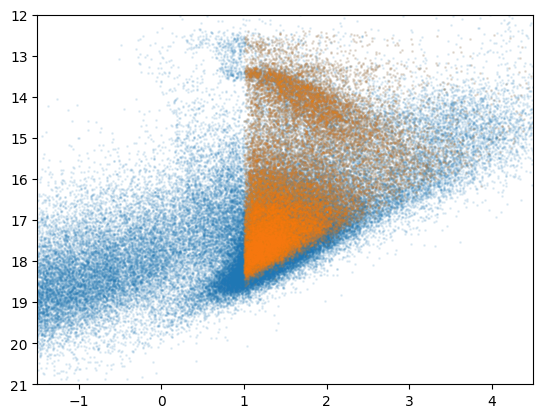

In [496]:
pl.scatter(basetable['mag_ab_f212n'] - basetable['mag_ab_f410m'], basetable['mag_ab_f410m'], s=1, alpha=0.1)
pl.scatter((basetable['mag_ab_f212n'] - basetable['mag_ab_f410m'])[ok], basetable['mag_ab_f410m'][ok], s=1, alpha=0.1)
pl.axis([-1.5, 4.5, 21, 12]);

# For 1182

In [442]:
fh444 = fits.open('/Users/adam/Dropbox/brick2221/20240802_FITS/jw01182-o004_t001_nircam_clear-f444w-merged_i2d.fits')
ww444 = wcs.WCS(fh444['SCI'].header)

Set DATE-AVG to '2022-09-17T08:50:39.483' from MJD-AVG.
Set DATE-END to '2022-09-20T00:27:24.591' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -4.389952 from OBSGEO-[XYZ].
Set OBSGEO-H to 1356250248.071 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [443]:
wholebrick_mask_444 = wholebrickreg.to_pixel(ww444).to_mask()
bigbrick_mask_444 = bigbrickreg.to_pixel(ww444).to_mask()
pixels_in_brick = np.isfinite(fh['SCI'].data) & (wholebrick_mask_444.to_image(fh['SCI'].data.shape).astype('bool'))
pixels_in_big_brick = np.isfinite(fh['SCI'].data) & (bigbrick_mask_444.to_image(fh['SCI'].data.shape).astype('bool'))
pixels_not_in_brick = np.isfinite(fh['SCI'].data) & ~(pixels_in_brick.astype('bool')) & ~(pixels_in_big_brick.astype('bool'))

f444_area_in_brick = pixels_in_brick.sum() * ww.proj_plane_pixel_area()
f444_area_not_in_brick = pixels_not_in_brick.sum() * ww.proj_plane_pixel_area()
f444_area_in_brick, f444_area_not_in_brick

(<Quantity 0.00065817 deg2>, <Quantity 0.00190385 deg2>)

/var/folders/k_/7qh4l0nn72b7qgq15pkd4hw40000gt/T/ipykernel_75926/1520916292.py:16: RuntimeWarning: divide by zero encountered in divide
  ratio_444 = H1 / H2 * f444_area_not_in_brick.value/f444_area_in_brick.value


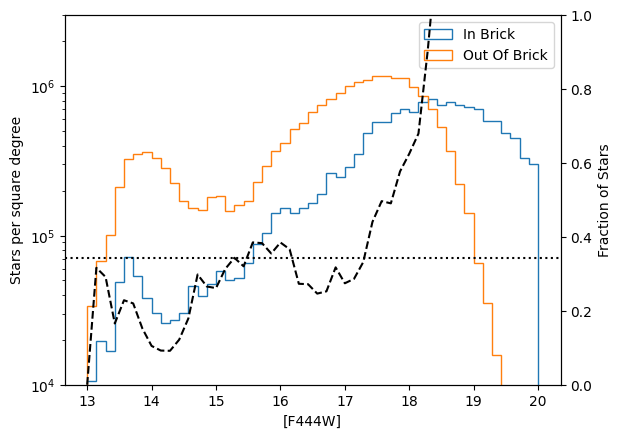

In [497]:
ok = (basetable['mag_ab_f356w'] - basetable['mag_ab_f444w']) > 0.25 # reddened = GC
ok &= basetable['emag_ab_f444w'] < 0.1 # min SNR
ok &= basetable['nmatch_good_f444w'] > 4
ok &= basetable['nmatch_good_f356w'] > 4
H1, L1, (p1,) = pl.hist(basetable['mag_ab_f444w'][ok & sel], bins=np.linspace(13, 20), histtype='step', label='In Brick',)
H2, L2, (p2,) =pl.hist(basetable['mag_ab_f444w'][ok & nonbrick_sel], bins=np.linspace(13, 20), histtype='step', label='Out Of Brick',)
pl.xlim(pl.xlim()[::-1]);
pl.legend(loc='best');
p1.set_xy(np.transpose([p1.xy[:,0], p1.xy[:, 1] / f444_area_in_brick.value]))
p2.set_xy(np.transpose([p2.xy[:,0], p2.xy[:, 1] / f444_area_not_in_brick.value]))
pl.ylim(1e4, 3e6); pl.yscale('log');
pl.xlabel("[F444W]");
pl.ylabel("Stars per square degree")

ax2 = pl.twinx()
ratio_444 = H1 / H2 * f444_area_not_in_brick.value/f444_area_in_brick.value
ax2.plot(L1, np.concatenate([[0], ratio_444]), color='k', linestyle='--')
ax2.axhline(np.median(ratio_444), linestyle=':', color='k')
ax2.set_xlabel("[F444w]")
ax2.set_ylabel("Fraction of Stars");
ax2.set_xlim(pl.xlim()[::-1]);
ax2.set_ylim(0, 1);

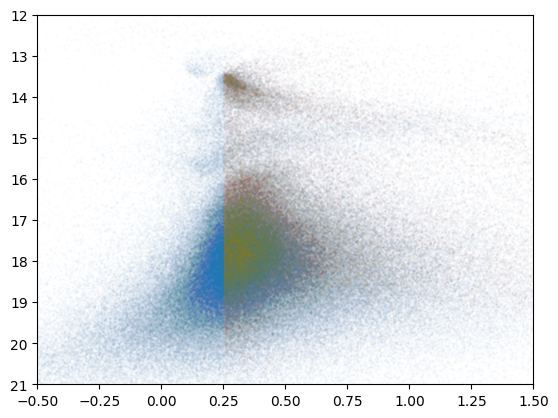

In [498]:
pl.scatter(basetable['mag_ab_f356w'] - basetable['mag_ab_f444w'], basetable['mag_ab_f444w'], s=1, alpha=0.01)
pl.scatter((basetable['mag_ab_f356w'] - basetable['mag_ab_f444w'])[ok], basetable['mag_ab_f444w'][ok], s=1, alpha=0.01)
pl.axis([-0.5, 1.5, 21, 12]);

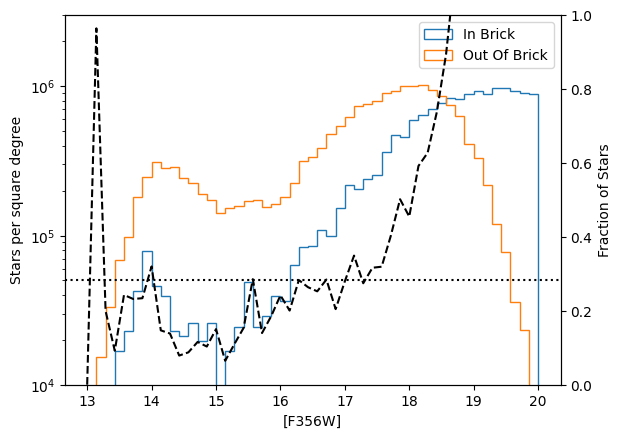

In [499]:
sel = wholebrickreg.contains(basetable['skycoord_ref'], ww)
ok = (basetable['mag_ab_f200w'] - basetable['mag_ab_f356w']) > 1.25 # reddened = GC
ok &= basetable['emag_ab_f356w'] < 0.1 # min SNR
ok &= basetable['nmatch_good_f200w'] > 4
ok &= basetable['nmatch_good_f356w'] > 4
H1, L1, (p1,) = pl.hist(basetable['mag_ab_f356w'][ok & sel], bins=np.linspace(13, 20), histtype='step', label='In Brick',)
H2, L2, (p2,) =pl.hist(basetable['mag_ab_f356w'][ok & nonbrick_sel], bins=np.linspace(13, 20), histtype='step', label='Out Of Brick',)
pl.xlim(pl.xlim()[::-1]);
pl.legend(loc='best');
p1.set_xy(np.transpose([p1.xy[:,0], p1.xy[:, 1] / f444_area_in_brick.value]))
p2.set_xy(np.transpose([p2.xy[:,0], p2.xy[:, 1] / f444_area_not_in_brick.value]))
pl.ylim(1e4, 3e6); pl.yscale('log');
pl.xlabel("[F356W]");
pl.ylabel("Stars per square degree")

ax2 = pl.twinx()
ratio_356 = H1 / H2 * f444_area_not_in_brick.value/f444_area_in_brick.value
ax2.plot(L1, np.concatenate([[0], ratio_356]), color='k', linestyle='--')
ax2.axhline(np.median(ratio_356), linestyle=':', color='k')
ax2.set_xlabel("[F356w]")
ax2.set_ylabel("Fraction of Stars");
ax2.set_xlim(pl.xlim()[::-1]);
ax2.set_ylim(0, 1);

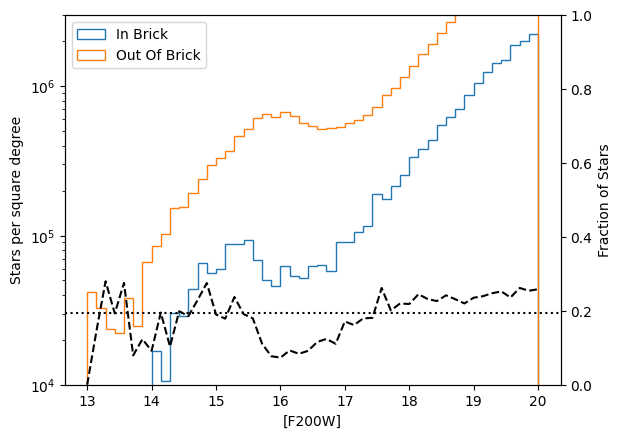

In [500]:
sel = wholebrickreg.contains(basetable['skycoord_ref'], ww)
ok = (basetable['mag_ab_f200w'] - basetable['mag_ab_f356w']) > 1.00 # reddened = GC
ok &= basetable['emag_ab_f200w'] < 0.1 # min SNR
H1, L1, (p1,) = pl.hist(basetable['mag_ab_f200w'][ok & sel], bins=np.linspace(13, 20), histtype='step', label='In Brick',)
H2, L2, (p2,) =pl.hist(basetable['mag_ab_f200w'][ok & nonbrick_sel], bins=np.linspace(13, 20), histtype='step', label='Out Of Brick',)
pl.xlim(pl.xlim()[::-1]);
pl.legend(loc='best');
p1.set_xy(np.transpose([p1.xy[:,0], p1.xy[:, 1] / f444_area_in_brick.value]))
p2.set_xy(np.transpose([p2.xy[:,0], p2.xy[:, 1] / f444_area_not_in_brick.value]))
pl.ylim(1e4, 3e6); pl.yscale('log');
pl.xlabel("[F200W]");
pl.ylabel("Stars per square degree")

ax2 = pl.twinx()

ratio_200 = H1 / H2 * f444_area_not_in_brick.value/f444_area_in_brick.value
ax2.plot(L1, np.concatenate([[0], ratio_200]), color='k', linestyle='--')
ax2.axhline(np.median(ratio_200), linestyle=':', color='k')

ax2.set_xlabel("[F200w]")
ax2.set_ylabel("Fraction of Stars");
ax2.set_xlim(pl.xlim()[::-1]);
ax2.set_ylim(0, 1);

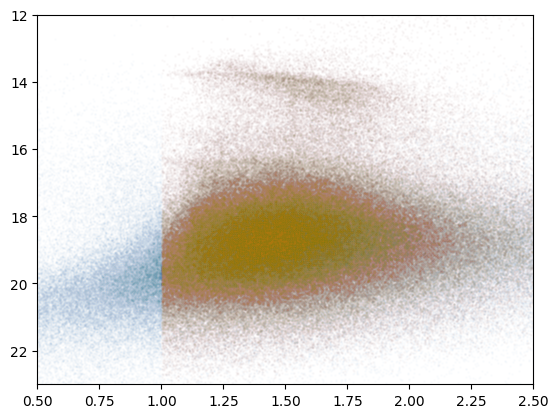

In [501]:
pl.scatter(basetable['mag_ab_f200w'] - basetable['mag_ab_f356w'], basetable['mag_ab_f356w'], s=1, alpha=0.01)
pl.scatter((basetable['mag_ab_f200w'] - basetable['mag_ab_f356w'])[ok], basetable['mag_ab_f356w'][ok], s=1, alpha=0.01)
pl.axis([0.5, 2.5, 23, 12]);

### Crossing datasets requires recomputing effective area

# Models

Chatzopoulos+ 2015 (https://ui.adsabs.harvard.edu/abs/2015MNRAS.447..948C/abstract)

$$\rho(R,z) = \Sigma_{i=1}^2 \frac{3-\gamma_i}{4\pi q_i} \frac{M_i a_i}{m_i^{\gamma_i} (m_i+a_i)^{4-\gamma_i}}$$

$$m_i = R^2 + z^2/q_i^2$$

Sormani+ 2020 give a fit to the Gallego-Cano 2020 fit

## Bulge Model

We need to incorporate foreground stars better.

In [502]:
from astropy import units as u
from astropy.visualization import simple_norm

In [503]:
distance = 8.1*u.kpc
rbrick = (distance * 0.253*u.deg).to(u.pc, u.dimensionless_angles())
zbrick = (distance * -0.015*u.deg).to(u.pc, u.dimensionless_angles())
rbrick, zbrick

(<Quantity 35.76703236 pc>, <Quantity -2.12057504 pc>)

In [504]:
((147.6*u.arcsec)*distance).to(u.pc, u.dimensionless_angles())

<Quantity 5.79623845 pc>

In [505]:
((4572*u.arcsec)*distance).to(u.pc, u.dimensionless_angles())

<Quantity 179.54202015 pc>

In [506]:
# Chatzopoulous is the source of most constants
# Sormani+ 2020 adds the more extended NSD
def chatz_nsc(R, z):
    gamma1 = 0.71
    distance = 8.1 # u.kpc
    a1 = 147.6 * distance * 1e3 / 206265
    q1 = 0.73
    m1 = R**2 + z**2/q1**2
    M1 = 6.17e7 # from Sormani 8.94e6 # not sure about this
    # 'rho' units here are... Msun per cubic parsec
    rho1 = (3-gamma1) / (4*np.pi*q1) * M1 * a1 / (m1**gamma1 * ( m1 + a1 ) ** (4-gamma1))
    # Chatz gives their measurements in msun/arcsec^3; I converted
    return (rho1)*u.M_sun/u.pc**3

def chatz_nsd(R, z):
    distance = 8.1 # u.kpc
    gamma2 = 0.07
    a2 = 4572 * distance * 1e3 / 2026265
    q2 = 0.28
    m2 = R**2 + z**2/q2**2
    M2 = 6.2e9 # according to Sormani
    rho2 = (3-gamma2) / (4*np.pi*q2) * M2 * a2 / (m2**gamma2 * ( m2 + a2 ) ** (4-gamma2))
    return rho2 * u.M_sun/u.pc**3

def gallego_cano_nsd(R, z):
    R = u.Quantity(R, u.pc)
    z = u.Quantity(z, u.pc)
    rho2 = 170e10 * u.Msun / u.kpc**3
    rho1 = 1.311 * rho2
    n1 = 0.72
    n2 = 0.79
    R1 = 5.06 * u.pc
    R2 = 24.6 * u.pc
    q = 0.37
    a = (R**2 + z**2 / q**2)**0.5

    # NSD from Sormani 2020 eqn 27
    rho3 = rho1 * np.exp(-(a/R1)**n1) #+ rho2 * np.exp(-(a/R2)**n2)
    return rho3

def mass_model(R, z):
    return chatz_nsd(R, z) + chatz_nsc(R, z)
def mass_model(R, z):
    return gallego_cano_nsd(R, z) + chatz_nsc(R, z)

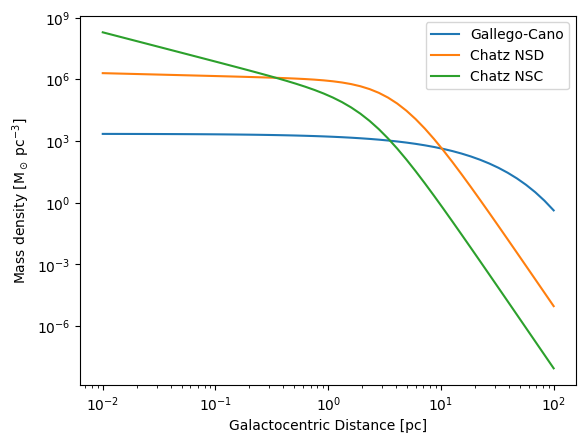

In [507]:
x = np.logspace(-2, 2);
pl.semilogy(x, gallego_cano_nsd(x, 0).to(u.M_sun/u.pc**3), label='Gallego-Cano')
pl.semilogy(x, chatz_nsd(x, 0).to(u.M_sun/u.pc**3), label='Chatz NSD')
pl.semilogy(x, chatz_nsc(x, 0).to(u.M_sun/u.pc**3), label='Chatz NSC');
pl.loglog();
pl.legend(loc='best');
pl.ylabel("Mass density [M$_\odot$ pc$^{-3}$]")
pl.xlabel("Galactocentric Distance [pc]");

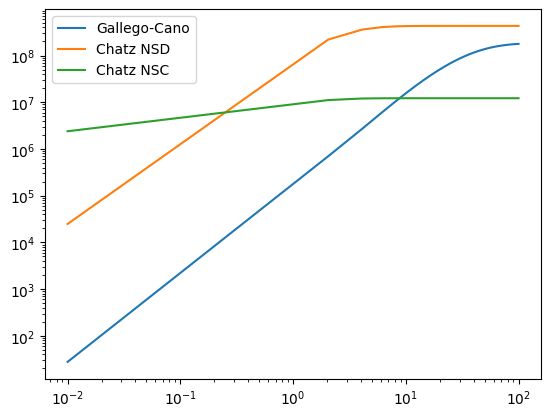

In [508]:
x = np.linspace(0.01, 100)
pl.semilogy(x, np.cumsum((np.pi*(x*u.pc)**2 * 40*u.pc)*gallego_cano_nsd(x, 0).to(u.M_sun/u.pc**3)), label='Gallego-Cano')
pl.semilogy(x, np.cumsum((np.pi*(x*u.pc)**2 * 40*u.pc)*chatz_nsd(x, 0).to(u.M_sun/u.pc**3)), label='Chatz NSD')
pl.semilogy(x, np.cumsum((np.pi*(x*u.pc)**2 * 40*u.pc)*chatz_nsc(x, 0).to(u.M_sun/u.pc**3)), label='Chatz NSC');
pl.loglog();
pl.legend(loc='best');

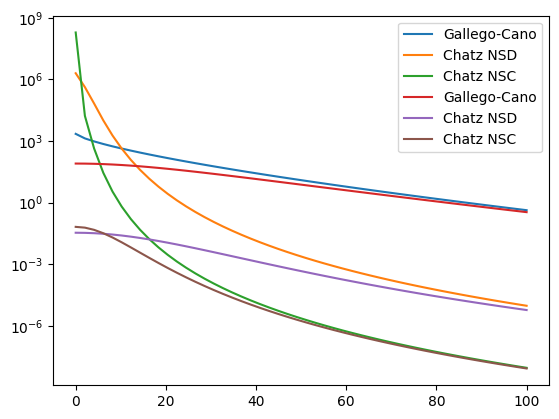

In [509]:
x = np.linspace(0.01, 100)
pl.semilogy(x, gallego_cano_nsd(x, 0).to(u.M_sun/u.pc**3), label='Gallego-Cano')
pl.semilogy(x, chatz_nsd(x, 0).to(u.M_sun/u.pc**3), label='Chatz NSD')
pl.semilogy(x, chatz_nsc(x, 0).to(u.M_sun/u.pc**3), label='Chatz NSC');
pl.semilogy(x, gallego_cano_nsd(x, 10).to(u.M_sun/u.pc**3), label='Gallego-Cano')
pl.semilogy(x, chatz_nsd(x, 10).to(u.M_sun/u.pc**3), label='Chatz NSD')
pl.semilogy(x, chatz_nsc(x, 10).to(u.M_sun/u.pc**3), label='Chatz NSC');
pl.legend(loc='best');

In [510]:
gallego_cano_nsd(1, 1).to(u.M_sun/u.pc**3)

<Quantity 1144.15144887 solMass / pc3>

In [511]:
chatz_nsc(1, 1)

<Quantity 34546.19147998 solMass / pc3>

In [512]:
chatz_nsd(1, 1)

<Quantity 95096.68979137 solMass / pc3>

In [513]:
mass_model(200, 0)

<Quantity 1648025.07010912 solMass / kpc3>

In [514]:
yy, xx = np.mgrid[:100, :100]
rr = (yy**2+xx**2)**0.5

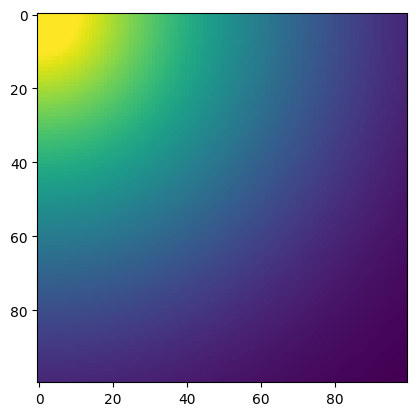

In [515]:
rho = mass_model(rr, -2.1)
pl.imshow(rho.value, norm=simple_norm(rho.value, stretch='log', max_percent=99))

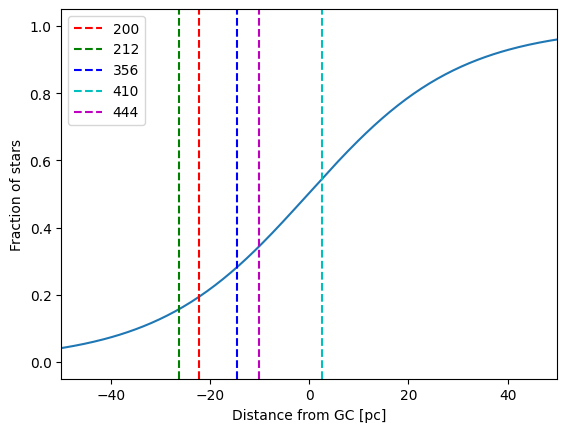

In [516]:
yy = np.linspace(-200, 200, 1000)
xx = 35.7
rr = (yy**2+xx**2)**0.5
zz = -2.1
rho = mass_model(rr, zz)
cfrac = np.cumsum(rho)/np.sum(rho)
pl.plot(yy, cfrac)
for xv, wl, col in zip((ratio_200, ratio_212, ratio_356, ratio_410, ratio_444),
                       (200, 212, 356, 410, 444),
                       ('rgbcm')
                      ):
    closest = np.abs((cfrac - np.nanmedian(xv))).argmin()
    pl.axvline(yy[closest], linestyle='--', label=str(wl), color=col);
pl.legend(loc='best')
pl.xlim(-50, 50);
pl.xlabel("Distance from GC [pc]")
pl.ylabel("Fraction of stars");

The above plot shows that for all the selections, the Brick is in front of center - but barely.

I don't know which selection to trust.

None of these show the Brick being anywhere near the 100 pc ring, but it would be virtually impossible for any cloud to be there given this model.

# AGAMA

In [517]:
# https://github.com/GalacticDynamics-Oxford/Agama/blob/master/py/example_mw_nsd.py

In [550]:
%run ~/repos/Agama/py/example_mw_nsd.py

ModuleNotFoundError: No module named 'agama'

# Extinction estimation

In [466]:
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC

In [521]:
av212410 = (basetable['mag_ab_f212n'] - basetable['mag_ab_f410m']) / (CT06_MWGC()(2.12*u.um) - CT06_MWGC()(4.10*u.um))
# but empirically, this value appears to start at 1.2 (f212n - f410m has a locus at -1.2)
av212410 = (1.2 + basetable['mag_ab_f212n'] - basetable['mag_ab_f410m']) / (CT06_MWGC()(2.12*u.um) - CT06_MWGC()(4.10*u.um))
# so why not just use the 182m?
av182212 = (basetable['mag_ab_f182m'] - basetable['mag_ab_f212n']) / (CT06_MWGC()(1.82*u.um) - CT06_MWGC()(2.12*u.um))
# or 182-410
av182410 = (basetable['mag_ab_f182m'] - basetable['mag_ab_f410m']) / (CT06_MWGC()(1.82*u.um) - CT06_MWGC()(4.10*u.um))
# or 187-405
av187405 = (basetable['mag_ab_f187n'] - basetable['mag_ab_f405n']) / (CT06_MWGC()(1.87*u.um) - CT06_MWGC()(4.05*u.um))

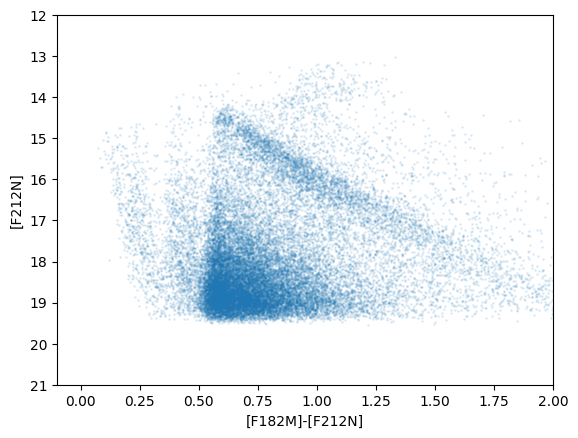

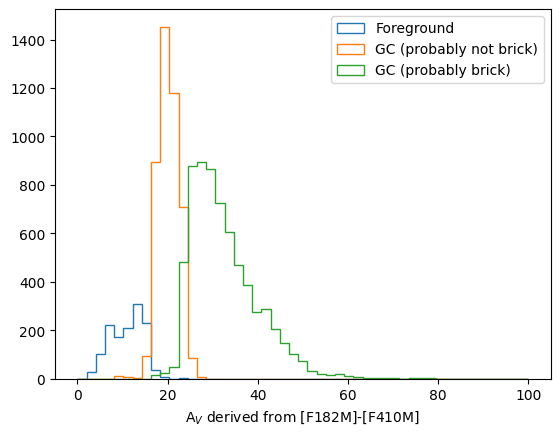

In [523]:
notbad = (
          (basetable['emag_ab_f212n'] < 0.1) &
          (basetable['emag_ab_f410m'] < 0.1) &
          (basetable['emag_ab_f182m'] < 0.1) &
          (basetable['nmatch_good_f212n'] > 4) &
          (basetable['nmatch_good_f182m'] > 4) &
          (basetable['nmatch_good_f410m'] > 4))

bright = ((basetable['mag_ab_f212n'] > 14) &
          (basetable['mag_ab_f212n'] < 18) & notbad)
          

pl.scatter((basetable['mag_ab_f182m'] - basetable['mag_ab_f212n'])[notbad], basetable['mag_ab_f212n'][notbad], s=1, alpha=0.1)
incl = wholebrickreg.contains(basetable['skycoord_ref'], ww) & notbad
#pl.scatter((basetable['mag_ab_f182m'] - basetable['mag_ab_f212n'])[incl], basetable['mag_ab_f212n'][incl], s=1, alpha=0.1)
#pl.scatter((basetable['mag_ab_f182m'] - basetable['mag_ab_f212n'])[bright], basetable['mag_ab_f212n'][bright], s=1, alpha=0.1)
pl.axis([-0.1, 2, 21, 12]);
pl.xlabel("[F182M]-[F212N]")
pl.ylabel("[F212N]");

pl.figure()
pl.hist(av182410[bright & ((basetable['mag_ab_f182m'] - basetable['mag_ab_f212n']) < 0.5)], bins=np.linspace(0, 100),
        label='Foreground', histtype='step', density=False);
pl.hist(av182410[bright & ((basetable['mag_ab_f182m'] - basetable['mag_ab_f212n']) < 0.75) & ((basetable['mag_ab_f182m'] - basetable['mag_ab_f212n']) > 0.5)], bins=np.linspace(0, 100),
        label='GC (probably not brick)', histtype='step', density=False);
pl.hist(av182410[bright & ((basetable['mag_ab_f182m'] - basetable['mag_ab_f212n']) > 0.75)], bins=np.linspace(0, 100),
        label='GC (probably brick)', histtype='step', density=False);
pl.legend(loc='best');
pl.xlabel("A$_V$ derived from [F182M]-[F410M]");

basetable[bright].write('/Users/adam/Dropbox/brick2221/20240802_FITS/basic_merged_indivexp_photometry_tables_merged_nirspeccand.fits',
                          overwrite=True)

In [549]:
CT06_MWGC()(4*u.um)

0.05487328